# Tropospheric bias
Conda env: `phd_v3`

See more: https://github.com/mickaellalande/PhD/blob/master/CICLAD/Himalaya/CMIP6_IPSL_bias/ta-global.ipynb

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 234 GB / percent used: 7.1 %


# Load model data

In [2]:
# Define period
period = slice('1982','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# Load AMIP
# tas = xr.open_mfdataset(
#     '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
#     combine='by_coords'
# ).sel(time=period)[var]-273.15

# Load HR
# tas_HR = xr.open_mfdataset(
#     '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
# ).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [4]:
# regridder_HR = xe.Regridder(tas_HR, tas, 'bilinear', periodic=True, reuse_weights=True)
# tas_HR_regrid = regridder_HR(tas_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc


In [4]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Compute clim

In [5]:
tas_clim = tas.mean('time')
# tas_HR_clim = tas_HR.mean('time')
# tas_HR_regrid_clim = tas_HR_regrid.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [6]:
tas_bias = tas_clim-tas_era_regrid_clim
# tas_bias = tas_HR_regrid_clim-tas_era_regrid_clim


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in version 0.6.
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.alpha' was renamed to grid.alpha in version 0.6.


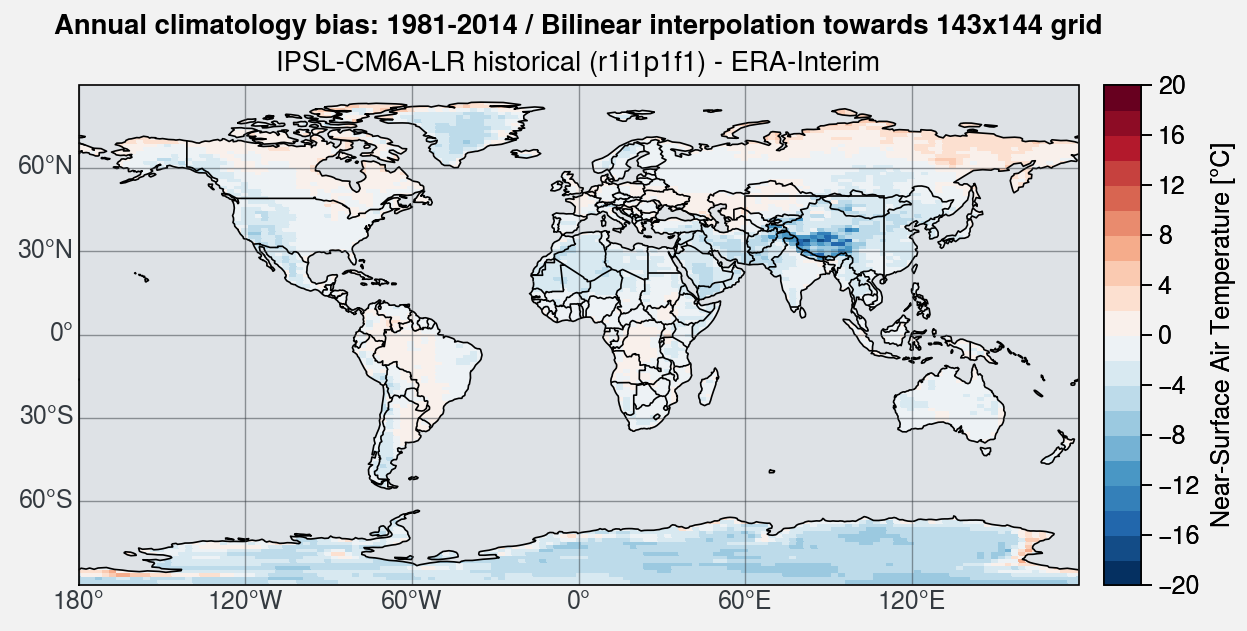

In [7]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')


# Add box   
axs[0].add_patch(mpatches.Rectangle(
    xy=[lonlim[0], latlim[0]], width=lonlim[1]-lonlim[0], height=latlim[1]-latlim[0],
    transform=ccrs.PlateCarree(), fill=False
))


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=60, latlines=30, abc=False
)

var = 'ta'

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [8]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# Load AMIP
# ps = xr.open_mfdataset(
#     '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
#     combine='by_coords'
# ).sel(time=period)[var]

# Load HR
# ps = xr.open_mfdataset(
#     '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
# ).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [9]:
ps_era_regrid = regridder(ps_era)

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Air Temperature

In [10]:
var ='ta'

# historical
ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

# AMIP
# ta = xr.open_mfdataset(
#     '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
# ).sel(time=period)[var].load()-273.15

# HR
# ta = xr.open_mfdataset(
#     '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
# ).sel(time=period)[var].load()-273.15

# ERA-Interim
ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

## Regrid horizontal

In [11]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)
# ta_regrid = regridder_HR(ta)

## Mask vertical values > ps

In [12]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [13]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [16]:
ta_clim = ta.mean('time', skipna=False).load()
# ta_regrid_clim = ta_regrid.mean('time', skipna=False).load()
ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values
# ta_bias = ta_regrid_clim-ta_era_regrid_masked_v_clim.values


# Plot longitude

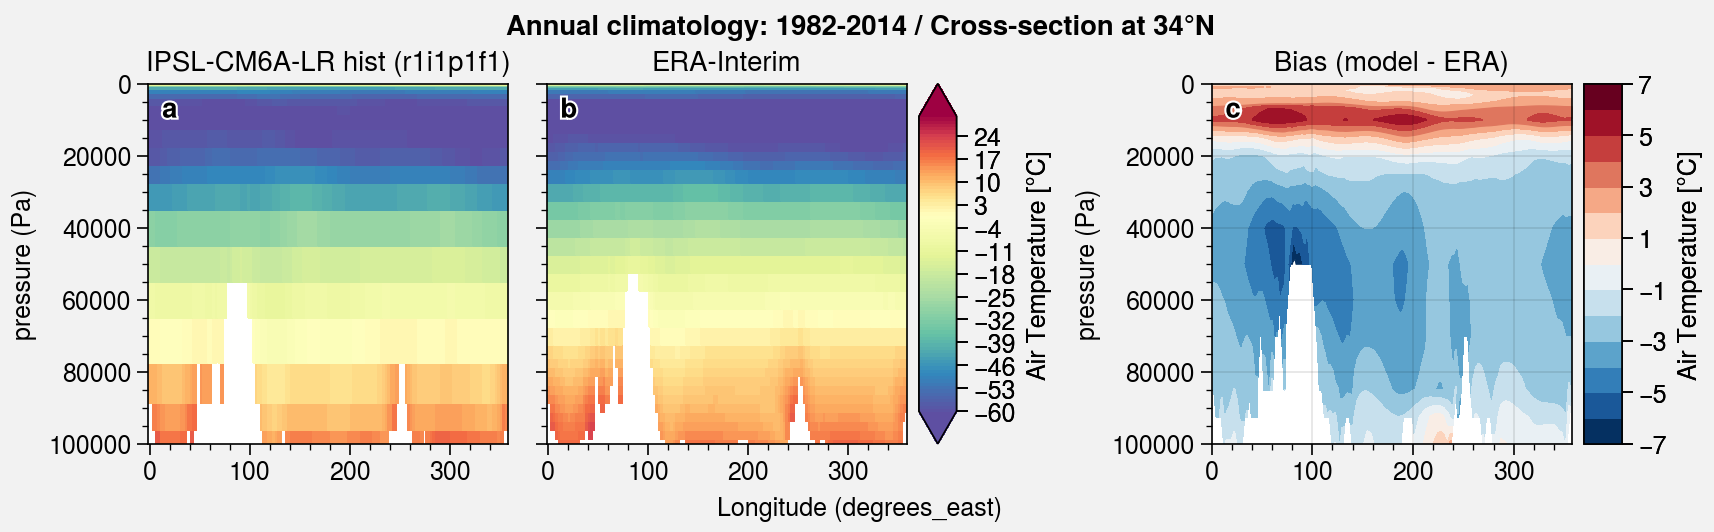

In [61]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral_r'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0, axwidth=1.8)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm=plot.Norm('midpoint', fair=False), extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR hist (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm=plot.Norm('midpoint', fair=False), extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim', yticklabelloc='neither', ylabel='')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1982-2014 / Cross-section at 34°N",
    abc=True, abcloc='ul'
)

f.save('img/slice_lat_34_ta_global_hist_ERAI.jpg')

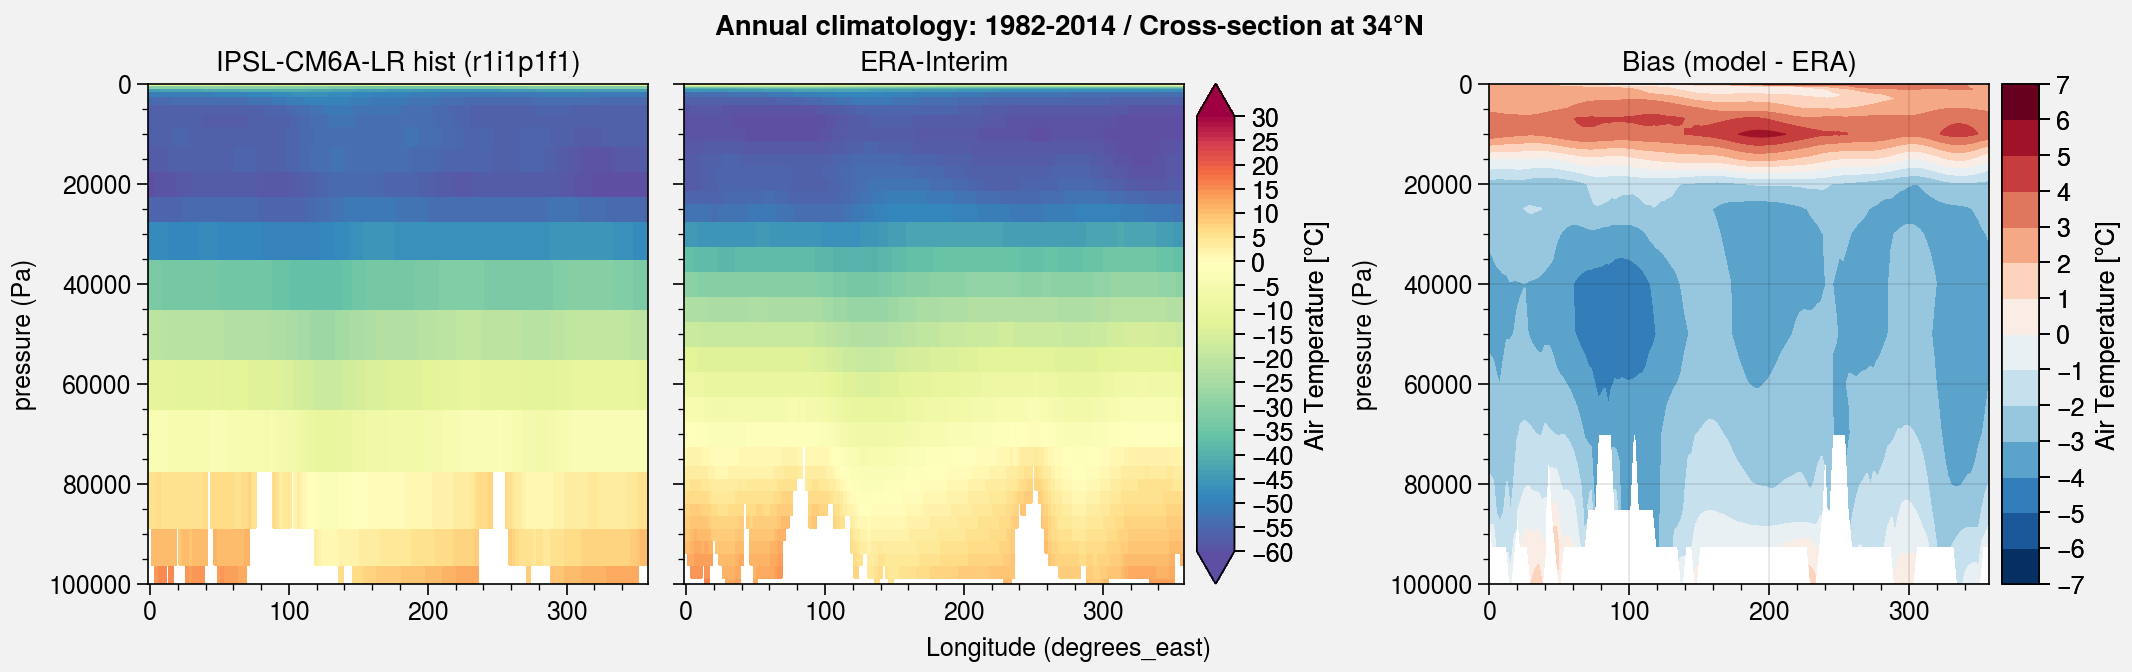

In [49]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral_r'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

lat=43

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=lat, method='nearest'), cmap=cmap, levels=levels, norm=plot.Norm('midpoint', fair=False), extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR hist (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=lat, method='nearest'), cmap=cmap, levels=levels, norm=plot.Norm('midpoint', fair=False), extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim', yticklabelloc='neither', ylabel='')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=lat, method='nearest'), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1982-2014 / Cross-section at 34°N"
)

# f.save('img/ta/slice_lat_34_ta_pcolormesh_global.png')
# f.save('img/ta/slice_lat_34_ta_pcolormesh_global.pdf')

# Save results

In [18]:
# historical
# ta_clim.to_netcdf('results/ta_clim_historical_1982_2014.nc')
# ta_bias.to_netcdf('results/ta_bias_historical_1982_2014.nc')

# AMIP
# ta_clim.to_netcdf('results/ta_clim_amip_1982_2014.nc')
# ta_bias.to_netcdf('results/ta_bias_amip_1982_2014.nc')

# HR
# ta_regrid_clim.to_netcdf('results/ta_clim_HR_1982_2014.nc')
# ta_bias.to_netcdf('results/ta_bias_HR_1982_2014.nc')

# Load results

In [3]:
# historical
ta_clim_hist = xr.open_dataarray('results/ta_clim_historical_1982_2014.nc')
ta_bias_hist = xr.open_dataarray('results/ta_bias_historical_1982_2014.nc')

# AMIP
ta_clim_amip = xr.open_dataarray('results/ta_clim_amip_1982_2014.nc')
ta_bias_amip = xr.open_dataarray('results/ta_bias_amip_1982_2014.nc')

# HR
ta_clim_HR = xr.open_dataarray('results/ta_clim_HR_1982_2014.nc')
ta_bias_HR = xr.open_dataarray('results/ta_bias_HR_1982_2014.nc')

In [6]:
ta_clim_list = [ta_clim_hist, ta_clim_amip, ta_clim_HR]
ta_bias_list = [ta_bias_hist, ta_bias_amip, ta_bias_HR]

# Plots

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nan

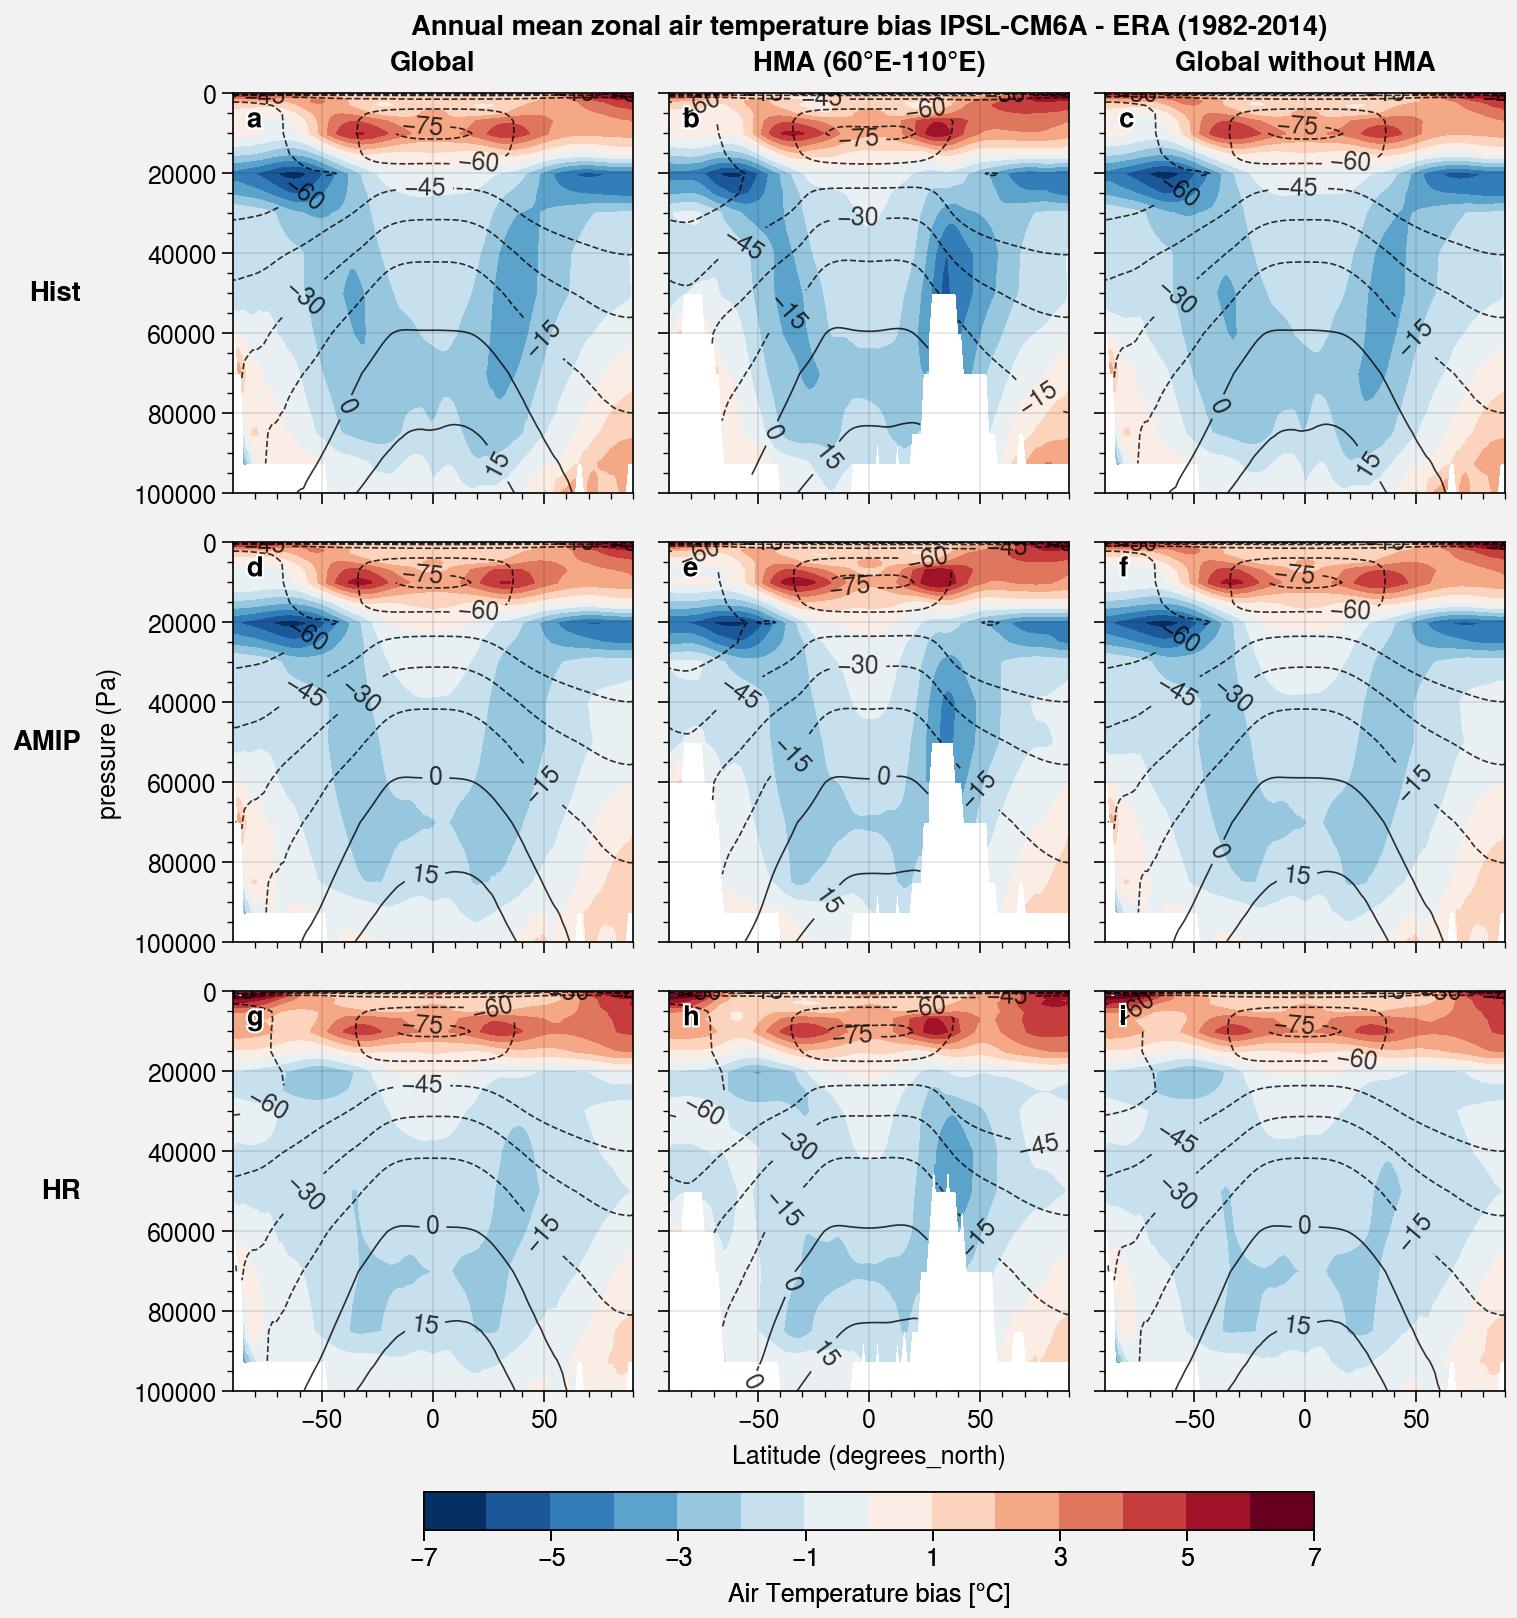

In [15]:
#Check colorbars 
levels=plot.arange(-7,7,1)
extend='both'
cmap='BuRd'

f, axs = plot.subplots(nrows=3, ncols=3, axwidth=2)

k = 0
for ta_clim, ta_bias in zip(ta_clim_list, ta_bias_list):
    # Global
    axs[k].contourf(ta_bias.mean('lon', skipna=True), cmap=cmap, levels=levels)
    axs[k].contour(ta_clim.mean('lon', skipna=True), color='black', labels=True, lw=0.6, alpha=0.8)
    k += 1
    # HMA
    axs[k].contourf(ta_bias.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False), cmap=cmap, levels=levels)
    axs[k].contour(ta_clim.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False), color='black', labels=True, lw=0.6, alpha=0.8)
    k += 1
    # Global without H%A
    m2 = axs[k].contourf(ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=True), cmap=cmap, levels=levels)
    axs[k].contour(ta_clim.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=True), color='black', labels=True, lw=0.6, alpha=0.8)
    k += 1
    
axs.format(ylim=(100000,0))
f.colorbar(m2, label='Air Temperature bias [°C]', loc='b', length=0.7)

axs.format(
    suptitle="Annual mean zonal air temperature bias IPSL-CM6A - ERA (1982-2014)", abc=True, abcloc='ul',
    collabels=['Global', 'HMA (60°E-110°E)', 'Global without HMA'],
    rowlabels=['Hist', 'AMIP', 'HR']
)

# filename = 'zonal_ta_global_HMA_contour'
f.save('img/zonal_ta_global_HMA_exps.jpg')